In [1]:
import json
import numpy as np
import os
import copy
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.gaussian_process.kernels import Matern


%matplotlib inline  


In [2]:
runs_dir = "/Users/martinweiss/PycharmProjects/tn-learn/info-bazaar/runs"
experiment_names = ["llama-70b-10q", "gpt-3.5-10q"]


In [52]:
summaries = defaultdict(list)
evaluations = defaultdict(list)
all_data = []

for experiment_name in experiment_names:
    exp_base_dir = os.path.join(runs_dir, experiment_name)
    seed_dirs = [d for d in os.listdir(exp_base_dir) if os.path.isdir(os.path.join(exp_base_dir, d))]

    for seed in tqdm(seed_dirs):
        seed_dir = os.path.join(exp_base_dir, seed)
        summary_path = os.path.join(seed_dir, "bazaar_summary.json")
        evaluation_path = os.path.join(seed_dir, "evaluation.json")
        try:
            with open(summary_path, "r") as f:
                summary = json.load(f)
            with open(evaluation_path, "r") as f:
                evaluation = json.load(f)

            num_blocks = {b['principal']['name']: len(b['principal']['answer']['blocks']) for b in summary['buyer_agents'] if b['principal']['answer'] is not None}

            for b in evaluation['buyer_agents']:
                flattened = {'experiment_name': experiment_name, 'seed': seed}
                for k, v in b.items():
                    if isinstance(v, dict):
                        for sub_k, sub_v in v.items():
                            flattened[f"{k}/{sub_k}"] = sub_v
                    else:
                        flattened[k] = v
                flattened['num_block'] = num_blocks.get(b['name'], None)
                all_data.append(flattened)

        except FileNotFoundError:
            pass
# Create a DataFrame
df = pd.DataFrame(all_data)
df['budget_used'] = df['max_budget'] - df['credit_left']


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00, 11.53it/s]


In [8]:
df.to_csv("final_dataframe.csv", index=False)

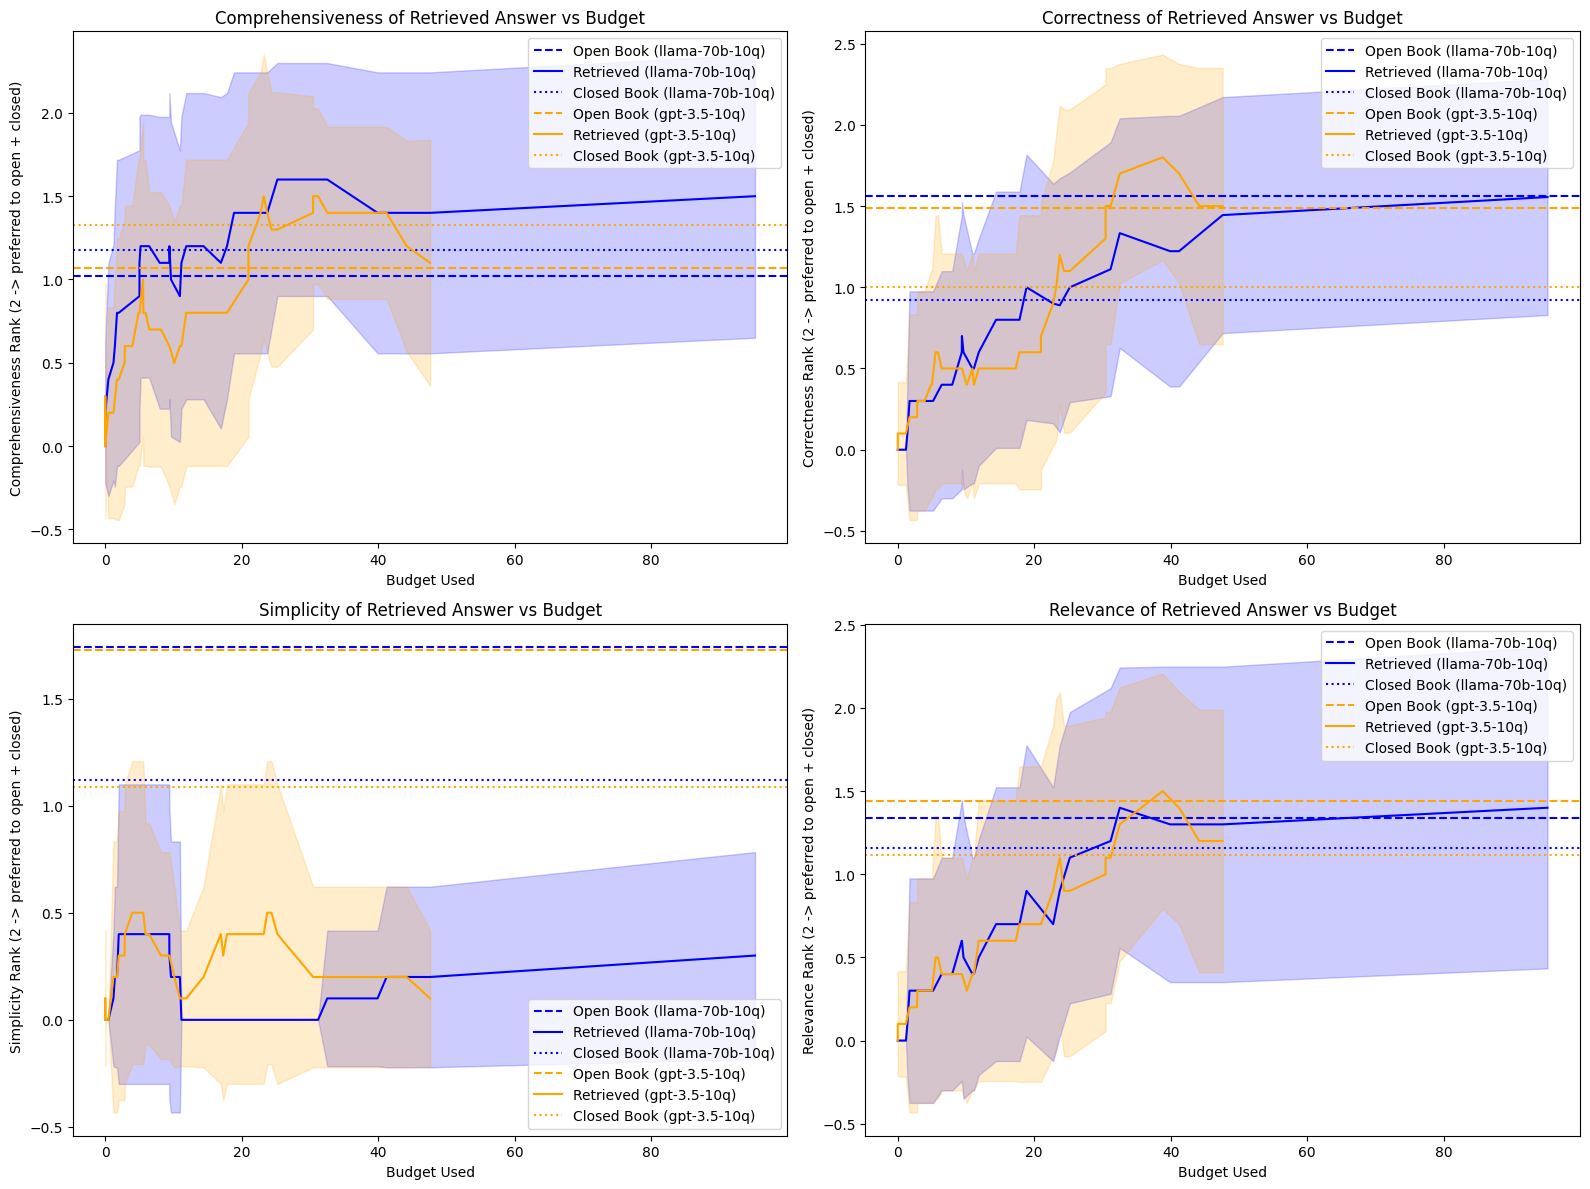

In [59]:
# Calculate budget used
dimensions = ['comprehensiveness', 'correctness', 'simplicity', 'relevance']

# Initialize plot
plt.figure(figsize=(16, 12))
colors = {'llama-70b-10q': 'blue', 'gpt-3.5-10q': 'orange'}

# Loop to create line plots with error bars for each dimension
for i, dim in enumerate(dimensions):
    plt.subplot(2, 2, i+1)
    
    for experiment in df['experiment_name'].unique():
        subset = df[df['experiment_name'] == experiment].sort_values(by='budget_used')
        
        # Calculate running average and standard deviation for retrieved data
        running_mean = subset[f'retrieved_answer_quality/{dim}'].rolling(window=10, min_periods=3).mean()
        running_std = subset[f'retrieved_answer_quality/{dim}'].rolling(window=10, min_periods=3).std()
        
        # Get the mean value of open book data
        open_book_mean = subset[f'open_book_answer_quality/{dim}'].mean()
        
        # Get the mean value of closed book data
        closed_book_mean = subset[f'closed_book_answer_quality/{dim}'].mean()
        
        # Plot a single horizontal line for the mean value of open book quality with the same color as the experiment
        plt.axhline(y=open_book_mean, color=colors[experiment], label=f"Open Book ({experiment})", linestyle='--')
        
        # Plot running average line for retrieved data
        plt.plot(subset['budget_used'], running_mean, color=colors[experiment], label=f"Retrieved ({experiment})")
        
        # Use Seaborn's fill_between for shaded area
        plt.fill_between(subset['budget_used'], running_mean - running_std, running_mean + running_std, color=colors[experiment], alpha=0.2)
        
        # Plot a single horizontal line for the mean value of closed book quality with the same color as the experiment
        plt.axhline(y=closed_book_mean, color=colors[experiment], label=f"Closed Book ({experiment})", linestyle=':')
        

    plt.title(f'{dim.capitalize()} of Retrieved Answer vs Budget')
    plt.xlabel('Budget Used')
    plt.ylabel(f'{dim.capitalize()} Rank (2 -> preferred to open + closed)')
    plt.legend(title='')

plt.tight_layout()
plt.show()


In [63]:
subset[f'retrieved_answer_quality/simplicity']

50     0
76     0
80     0
81     0
82     0
      ..
79     0
89     0
103    0
86     0
97     0
Name: retrieved_answer_quality/simplicity, Length: 70, dtype: int64

In [62]:
subset.columns

Index(['experiment_name', 'seed', 'name', 'question_text', 'max_budget',
       'credit_left', 'successfully_answered', 'answer_text',
       'gold_block_ware_specs', 'gold_block_content', 'gold_block_rejected',
       'retrieved_answer_quality/comprehensiveness',
       'retrieved_answer_quality/correctness',
       'retrieved_answer_quality/simplicity',
       'retrieved_answer_quality/relevance',
       'open_book_answer_quality/comprehensiveness',
       'open_book_answer_quality/correctness',
       'open_book_answer_quality/simplicity',
       'open_book_answer_quality/relevance',
       'closed_book_answer_quality/comprehensiveness',
       'closed_book_answer_quality/correctness',
       'closed_book_answer_quality/simplicity',
       'closed_book_answer_quality/relevance', 'open_book_answer',
       'closed_book_answer', 'num_block', 'budget_used'],
      dtype='object')

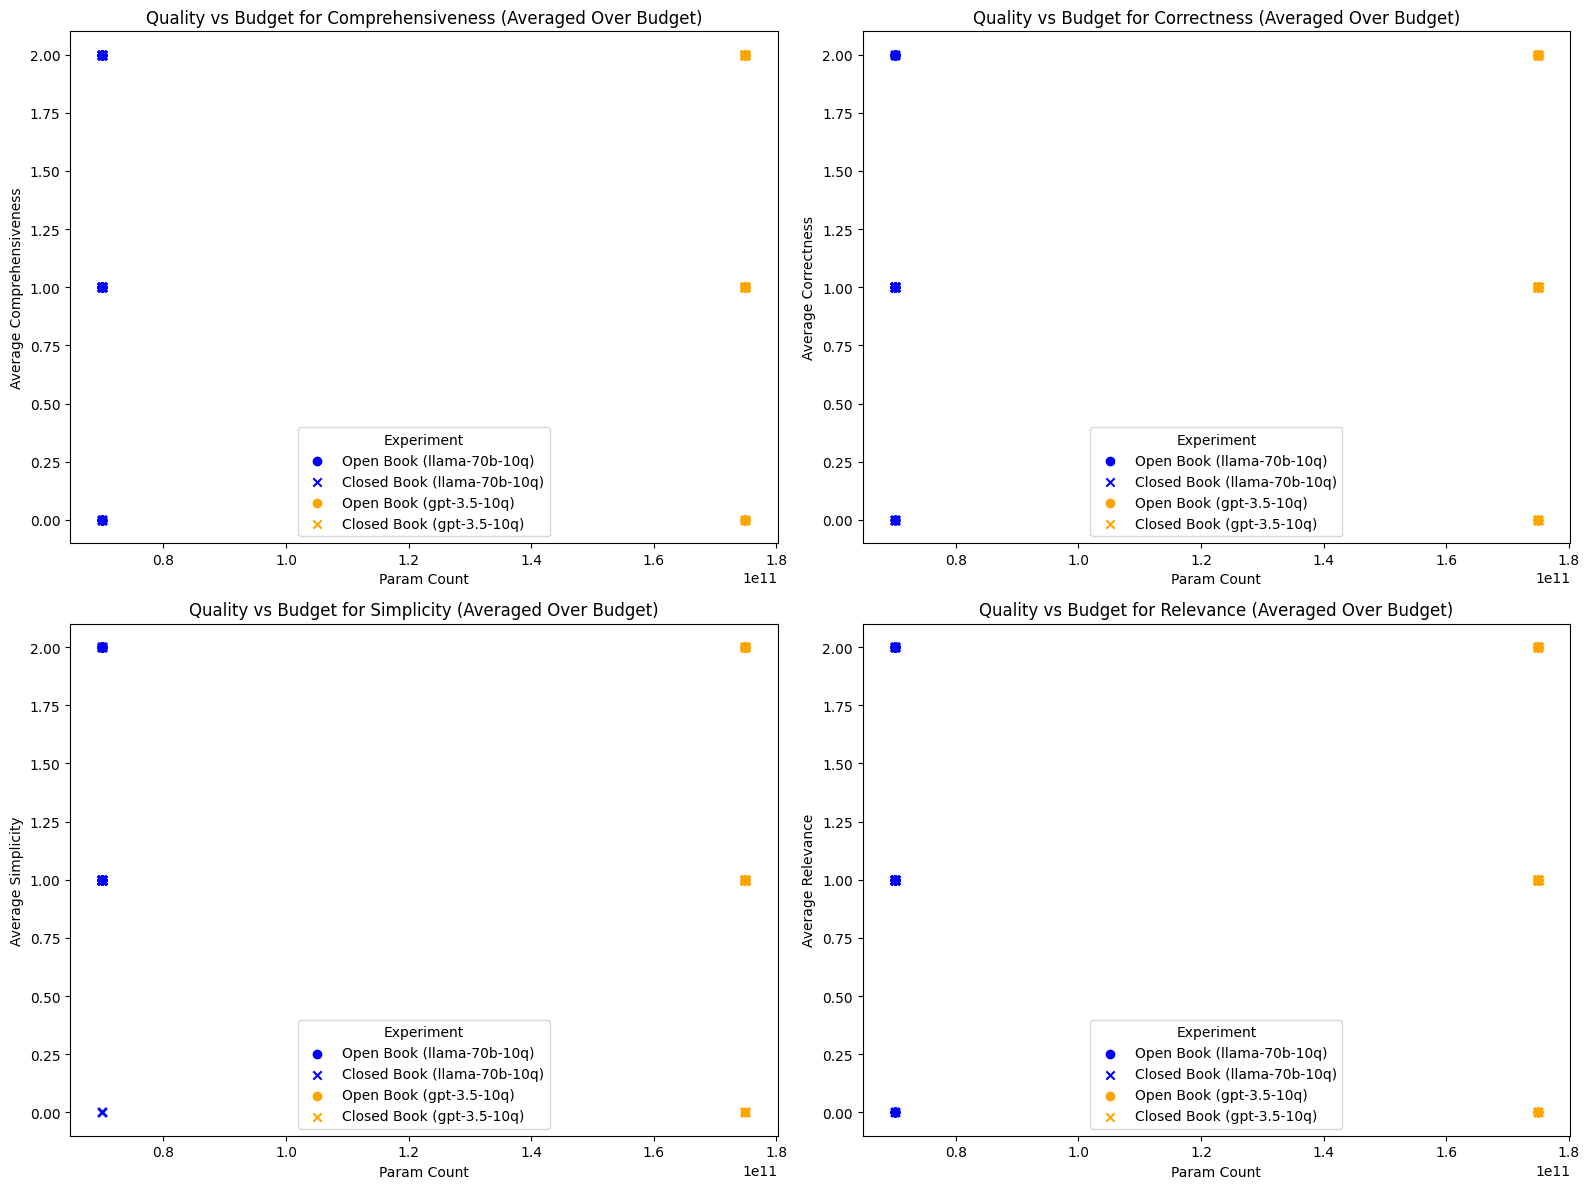

In [58]:
plt.figure(figsize=(16, 12))
colors = {'llama-70b-10q': 'blue', 'gpt-3.5-10q': 'orange'}
param_counts = {'llama-70b-10q': 70_000_000_000, 'gpt-3.5-10q': 175_000_000_000}

# Loop to create scatterplots for each dimension
for i, dim in enumerate(dimensions):
    plt.subplot(2, 2, i+1)
    
    for experiment in df_new['experiment_name'].unique():
        # Filter data for the current dimension and experiment
        subset = df_new[df_new['experiment_name'] == experiment]
        
        # Group and calculate the mean quality for open book and closed book over budget values
        open_book = subset[f'open_book_answer_quality/{dim}']
        closed_book = subset[f'closed_book_answer_quality/{dim}']
        x_val =np.array(param_counts[experiment]).repeat(open_book.shape[0])
        # Plot scatter points for averaged open book quality with the same color as the experiment
        plt.scatter(x_val, open_book, color=colors[experiment], label=f"Open Book ({experiment})")
        
        # Plot scatter points for averaged closed book quality with the same color as the experiment
        plt.scatter(x_val, closed_book, marker='x', color=colors[experiment], label=f"Closed Book ({experiment})")
        

    plt.title(f'Quality vs Budget for {dim.capitalize()} (Averaged Over Budget)')
    plt.xlabel('Param Count')
    plt.ylabel(f'Average {dim.capitalize()}')
    plt.legend(title='Experiment')

plt.tight_layout()
plt.show()
